In [1]:
from itertools import product
import graspy as gp
import numpy as np
import pandas as pd
from hyppo.ksample import KSample
from joblib import Parallel, delayed

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm_notebook as tqdm

from numpy.linalg import norm

from src import estimate_embeddings
%matplotlib inline

/home/ubuntu/env/miniconda3/envs/dnd/lib/python3.8/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.mixture.gaussian_mixture module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.mixture. Anything that cannot be imported from sklearn.mixture is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
def rotate(x, angle):
    rads = (angle * np.pi) / 180
    rotated = np.array([
        np.cos(rads) * x[0] - np.sin(rads) * x[1],
        np.sin(rads) * x[0] + np.cos(rads) * x[1],
    ])
    
    return rotated

# def angle(x, y):
#     rads = np.arccos(np.dot(x, y) / (norm(x) * norm(y)))
#     degs = rads / np.pi * 180
#     return degs

def find_angle(x, y, target):
    angle = np.arccos(target / (np.linalg.norm(x) * np.linalg.norm(y))) / np.pi * 180
    return angle

In [3]:
def generate_graphs_4(p, effect_size, block_size, num_graphs, initial_angle=60., **kwargs):
    """
    Initial angle of 60 means half of p is off diagonal
    """
    assert (1. + effect_size) <= (1 / p)
    X1 = np.array([p, p])
    X2 = rotate(X1, initial_angle)
    off_diag = X1 @ X2
    X3 = X2 * np.sqrt(1+effect_size)
    X3 = rotate(X3, find_angle(X1, X3, off_diag)-initial_angle)

    X = np.repeat(np.array([X1, X2]), block_size, axis=0)
    Y = np.repeat(np.array([X1, X3]), block_size, axis=0)
    
    P1 = X @ X.T
    P2 = Y @ Y.T
    
    G1 = np.array([gp.simulations.sample_edges(P1) for _ in range(num_graphs)])
    G2 = np.array([gp.simulations.sample_edges(P2) for _ in range(num_graphs)])
    
    return G1, G2

In [4]:
def experiment(m, n, p, effect_size, angle, generate_func, reps=100):
    block_size = n // 2
    m_per_pop = m // 2

    def worker():
        pvals = np.zeros((3, n))
        X, Y = generate_func(p, effect_size, block_size, m_per_pop, angle)

        for node in range(n):
            test = KSample("Dcorr").test(X[:, node, :], Y[:, node, :])
            pvals[0, node] = test[1]

        for j, method in enumerate(['omni', 'mase'], start=1):
            embeddings = estimate_embeddings(X, Y, method, 2, sample_space=True)
            Xhat = embeddings[:m_per_pop]
            Yhat = embeddings[m_per_pop:]
            for node in range(n):
                test = KSample("Dcorr").test(Xhat[:, node, :], Yhat[:, node, :])
                pvals[j, node] = test[1]

        return pvals

    res = Parallel(100)(delayed(worker)() for _ in range(reps))
    res = np.array(res)
    res = (res < 0.05).mean(axis=0)
    avg_pval_1 = res[:, :block_size].mean(axis=1)
    avg_pval_2 = res[:, block_size:].mean(axis=1)

    to_append = [m, n, effect_size, angle, generate_func.__name__, *avg_pval_1, *avg_pval_2]
    return to_append

In [5]:
ms = np.linspace(0, 200, 6, dtype=int)[1:]
ns = np.linspace(0, 200, 6, dtype=int)[1:]
effect_sizes = [0, 0.1, .3]
angles = [0, 60]
p = 0.5

args = [
    dict(p=p, m=m, n=n, effect_size=effect_size, angle=angle, generate_func=generate_graphs_4) 
    for m, n, effect_size, angle
    in product(ms, ns, effect_sizes, angles)
]

In [5]:
res = []
for arg in tqdm(args):
    res.append(experiment(**arg))

columns = ["m", "n", "effect_size", "angle", "model",
           "row_wise_same", "omni_same", "mase_same", 
           "row_wise_diff", "omni_diff", "mase_diff"]

df = pd.DataFrame(res, columns=columns)
df = df.sort_values(['effect_size', 'n','m'])
df.to_csv("./results/20200509_rdpg_powers_all.csv", index=False)

In [7]:
dfs = pd.read_csv("./results/20200509_rdpg_powers_all.csv")

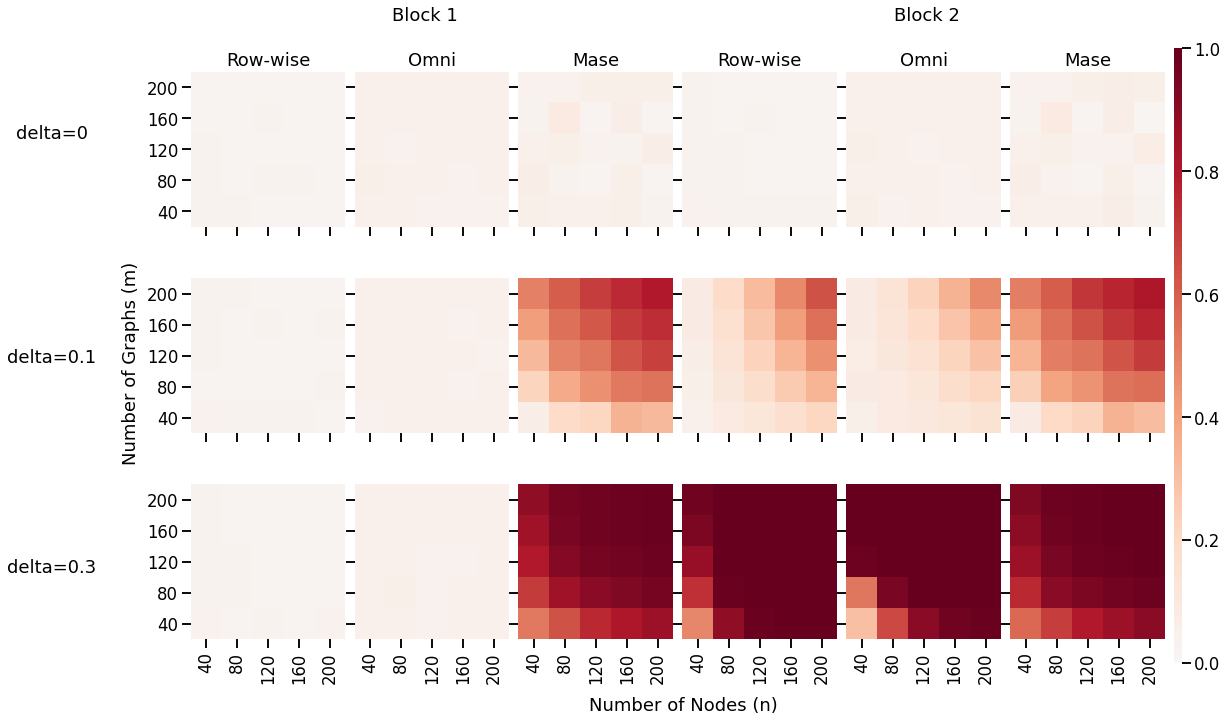

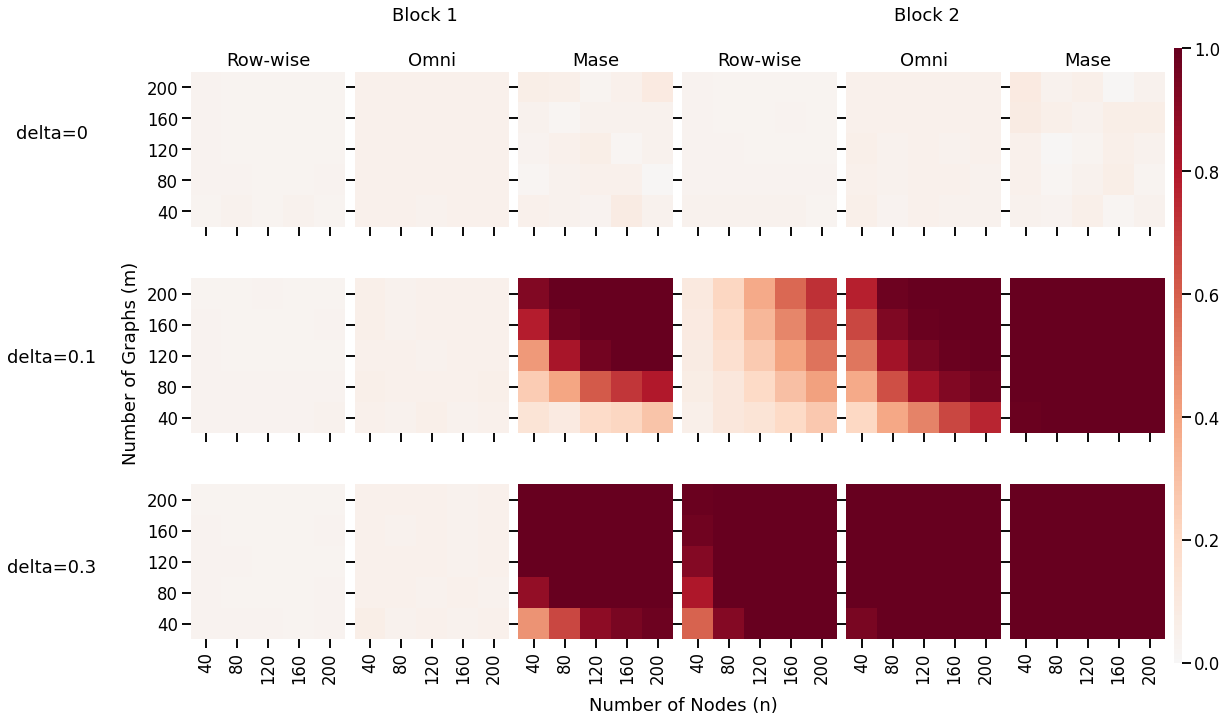

In [8]:
sns.set_context('talk')


for idx, model in enumerate(np.unique(dfs.angle)):
    fig, ax = plt.subplots(
        3, 
        7, 
        figsize=(15, 9),
        sharex=True,
        sharey=True,
        constrained_layout=True,
        gridspec_kw={"width_ratios": [1, 1, 1, 1, 1, 1, 0.05]},
    )

    gs = ax[-1, -1].get_gridspec()
    for ax_ in ax[:, -1]:
        ax_.remove()
    ax_leg = fig.add_subplot(gs[:, -1])

    col_names = ["Row-wise", 'Omni', 'Mase']
    
    tmp_df = dfs[dfs.angle == model]

    for row, effect_size in enumerate(pd.unique(tmp_df.effect_size)):
        for col, method in enumerate(tmp_df.columns[5:]):
            tmp = tmp_df[tmp_df.effect_size == effect_size][method]
            sns.heatmap(
                np.flipud(tmp.values.reshape(5, 5)),
                square=True,
                cmap='RdBu_r',
                center=0,
                cbar_ax=ax_leg,
                ax = ax[row, col],
                xticklabels=ns,
                yticklabels=ms[::-1],
                vmin=0,
                vmax=1
            )

            if row == 0:
                ax[row, col].set_title(col_names[col % 3])

    fig.text(0.26, 1.035, "Block 1", va="center", ha="center")
    fig.text(0.725, 1.035, "Block 2", va="center", ha="center")


    row_3 = "delta=0.3"
    row_2 = "delta=0.1"
    row_1 = "delta=0"

    fig.text(-0.085, 0.175, row_3, ha="center")
    fig.text(-0.085, 0.5, row_2, ha="center")
    fig.text(-0.085, 0.845, row_1, ha="center")

    fig.text(0.5, -0.03, "Number of Nodes (n)", va="center", ha="center")
    fig.text(-0.02, 0.5, "Total Number of Graphs (2m)", va="center", rotation="vertical")
    fig.savefig(f"./figures/20200509_rdpg_angle_{model}.png", dpi=300, bbox_inches='tight')